<a href="https://colab.research.google.com/github/Temmy-bit/OCR/blob/main/EMNIST%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/full-stack-deep-learning/fsdl-text-recognizer-2021-labs
%cd fsdl-text-reconizer-2021-labs
# !pip install pytorch_lightning
%env PYTHONPATH=.:$PYTHONPATH

# --INSERT--

Cloning into 'fsdl-text-recognizer-2021-labs'...
remote: Enumerating objects: 798, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 798 (delta 218), reused 194 (delta 194), pack-reused 484
Receiving objects: 100% (798/798), 18.85 MiB | 30.40 MiB/s, done.
Resolving deltas: 100% (398/398), done.
[Errno 2] No such file or directory: 'fsdl-text-reconizer-2021-labs'
/content/fsdl-text-recognizer-2021-labs/lab2/notebooks
env: PYTHONPATH=.:$PYTHONPATH


In [ ]:
from typing import Any, Dict
import argparse as args

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import time 
import copy

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/fsdl-text-recognizer-2021-labs

/content/fsdl-text-recognizer-2021-labs


In [ ]:
%cd lab2/notebooks

/content/fsdl-text-recognizer-2021-labs/lab2/notebooks


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!pip install toml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.emnist import EMNIST

In [ ]:
data = EMNIST()
data.prepare_data()
data.setup()
print(data)

EMNIST Dataset
Num classes: 83
Mapping: ['<B>', '<S>', '<E>', '<P>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '?']
Dims: (1, 28, 28)
Train/val/test sizes: 260212, 65054, 53988
Batch x stats: (torch.Size([128, 1, 28, 28]), torch.float32, tensor(0.), tensor(0.1771), tensor(0.3342), tensor(1.))
Batch y stats: (torch.Size([128]), torch.int64, tensor(4), tensor(65))



In [ ]:
x, y = next(iter(data.test_dataloader()))
print(x.shape, x.dtype, x.min(), x.mean(), x.std(), x.max())
print(y.shape, y.dtype, y.min(), y.max())

torch.Size([128, 1, 28, 28]) torch.float32 tensor(0.) tensor(0.2215) tensor(0.3603) tensor(1.)
torch.Size([128]) torch.int64 tensor(4) tensor(4)


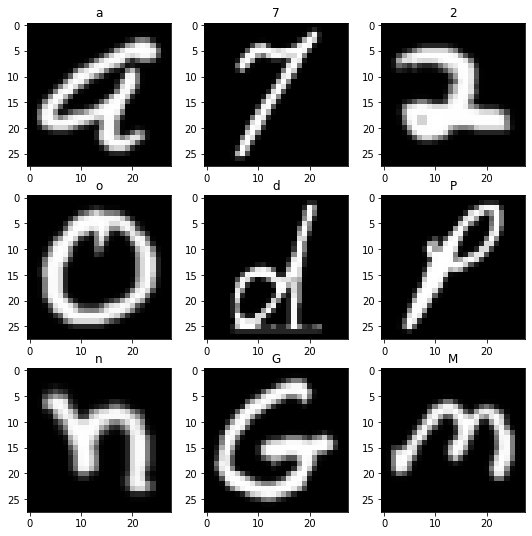

In [ ]:
fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    rand_i = np.random.randint(len(data.data_test))
    image, label = data.data_test[rand_i]
    ax.imshow(image.reshape(28, 28), cmap='gray')
    ax.set_title(data.mapping[label])

In [ ]:
CONV_DIM = 64
FC_DIM = 128
IMAGE_SIZE = 28


class ConvBlock(nn.Module):
    """
    Simple 3x3 conv with padding size 1 (to leave the input size unchanged), followed by a ReLU.
    """

    def __init__(self, input_channels: int, output_channels: int) -> None:
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x
            of dimensions (B, C, H, W)

        Returns
        -------
        torch.Tensor
            of dimensions (B, C, H, W)
        """
        c = self.conv(x)
        r = self.relu(c)
        return r


In [ ]:
class CNN(nn.Module):
    """Simple CNN for recognizing characters in a square image."""

    def __init__(self, data_config: Dict[str, Any]) -> None:
        super().__init__()
        self.args = vars(args) if args is not None else {}

    
        input_dims = data_config["input_dims"]
        num_classes = len(data_config["mapping"])

        conv_dim = self.args.get("conv_dim", CONV_DIM)
        fc_dim = self.args.get("fc_dim", FC_DIM)

        self.conv1 = ConvBlock(input_dims[0], conv_dim)
        self.conv2 = ConvBlock(conv_dim, conv_dim)
        self.dropout = nn.Dropout(0.25)
        self.max_pool = nn.MaxPool2d(2)

        # Because our 3x3 convs have padding size 1, they leave the input size unchanged.
        # The 2x2 max-pool divides the input size by 2. Flattening squares it.
        conv_output_size = IMAGE_SIZE // 2
        fc_input_dim = int(conv_output_size * conv_output_size * conv_dim)
        self.fc1 = nn.Linear(fc_input_dim, fc_dim)
        self.fc2 = nn.Linear(fc_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
        x
            (B, C, H, W) tensor, where H and W must equal IMAGE_SIZE

        Returns
        -------
        torch.Tensor
            (B, C) tensor
        """
        _B, _C, H, W = x.shape
        assert H == W == IMAGE_SIZE
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

        
    @staticmethod
    def add_to_argparse(parser):
        parser.add_argument("--conv_dim", type=int, default=CONV_DIM)
        parser.add_argument("--fc_dim", type=int, default=FC_DIM)
        return parser

In [ ]:
import pytorch_lightning as pl

In [ ]:
class BaseLitModel(pl.LightningModule):  # pylint: disable=too-many-ancestors
    """
    Generic PyTorch-Lightning class that must be initialized with a PyTorch module.
    """

    def __init__(self, model, args: argparse.Namespace = None):
        super().__init__()
        self.model = model
        self.args = vars(args) if args is not None else {}

        optimizer = self.args.get("optimizer", OPTIMIZER)
        self.optimizer_class = getattr(torch.optim, optimizer)

        self.lr = self.args.get("lr", LR)

        loss = self.args.get("loss", LOSS)
        if loss not in ("ctc", "transformer"):
            self.loss_fn = getattr(torch.nn.functional, loss)

        self.one_cycle_max_lr = self.args.get("one_cycle_max_lr", None)
        self.one_cycle_total_steps = self.args.get("one_cycle_total_steps", ONE_CYCLE_TOTAL_STEPS)

        self.train_acc = Accuracy()
        self.val_acc = Accuracy()
        self.test_acc = Accuracy()

    @staticmethod
    def add_to_argparse(parser):
        parser.add_argument("--optimizer", type=str, default=OPTIMIZER, help="optimizer class from torch.optim")
        parser.add_argument("--lr", type=float, default=LR)
        parser.add_argument("--one_cycle_max_lr", type=float, default=None)
        parser.add_argument("--one_cycle_total_steps", type=int, default=ONE_CYCLE_TOTAL_STEPS)
        parser.add_argument("--loss", type=str, default=LOSS, help="loss function from torch.nn.functional")
        return parser

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        if self.one_cycle_max_lr is None:
            return optimizer
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer, max_lr=self.one_cycle_max_lr, total_steps=self.one_cycle_total_steps
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):  # pylint: disable=unused-argument
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("train_loss", loss)
        self.train_acc(logits, y)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):  # pylint: disable=unused-argument
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(logits, y)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):  # pylint: disable=unused-argument
        x, y = batch
        logits = self(x)
        self.test_acc(logits, y)
        self.log("test_acc", self.test_acc, on_step=False, on_epoch=True)


In [ ]:
OPTIMIZER = "Adam"
LR = 1e-3
LOSS = "cross_entropy"
ONE_CYCLE_TOTAL_STEPS = 100

In [ ]:
from torchmetrics.classification import Accuracy

In [ ]:
class Accuracy(Accuracy):
    """Accuracy Metric with a hack."""

    def update(self, preds: torch.Tensor, target: torch.Tensor) -> None:
        """
        Metrics in Pytorch-lightning 1.2+ versions expect preds to be between 0 and 1 else fails with the ValueError:
        "The `preds` should be probabilities, but values were detected outside of [0,1] range."
        This is being tracked as a bug in https://github.com/PyTorchLightning/metrics/issues/60.
        This method just hacks around it by normalizing preds before passing it in.
        Normalized preds are not necessary for accuracy computation as we just care about argmax().
        """
        if preds.min() < 0 or preds.max() > 1:
            preds = torch.nn.functional.softmax(preds, dim=-1)
        super().update(preds=preds, target=target)

In [ ]:
model = CNN(data_config=data.config())
lit_model = BaseLitModel(model=model)
trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(lit_model, datamodule=data)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type     | Params
---------------------------------------
0 | model     | CNN      | 1.7 M 
1 | train_acc | Accuracy | 0     
2 | val_acc   | Accuracy | 0     
3 | test_acc  | A

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
!dir

01-look-at-emnist.ipynb        fsdl-text-recognizer-2021-labs
02-look-at-emnist-lines.ipynb  lightning_logs


In [ ]:
%cd ..

/content/fsdl-text-recognizer-2021-labs/lab2


In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.7 MB/s 
     |████████████████████████████████| 181 kB 75.3 MB/s 
     |████████████████████████████████| 157 kB 77.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 157 kB 77.5 MB/s 
     |████████████████████████████████| 157 kB 63.2 MB/s 
     |████████████████████████████████| 157 kB 82.2 MB/s 
     |████████████████████████████████| 157 kB 74.8 MB/s 
     |████████████████████████████████| 156 kB 79.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0095111b5b83a15c9d9aaa6c2e6f51b4f1a5d6057f10177bd138891e54c4d885
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
!python training/run_experiment.py --max_epochs 5 --gpus 1 --data_class EMNIST --model_class CNN

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:58: LightningDeprecationWarning: Setting `Trainer(weights_save_path=)` has been deprecated in v1.6 and will be removed in v1.8. Please pass ``dirpath`` directly to the `ModelCheckpoint` callback
  "Setting `Trainer(weights_save_path=)` has been deprecated in v1.6 and will be"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: training/logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     |

In [86]:
logits = model(x)
print(logits.shape)
preds = logits.argmax(-1)
print(y,preds)

torch.Size([128, 83])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4]) tensor([54,  4,  4, 28,  4, 28, 28,  4,  4,  4,  4,  4,  4, 54,  4,  4,  4, 28,
         4, 28,  4,  4,  4, 28,  4,  4, 28,  4,  4,  4,  4,  4,  4,  4, 54, 28,
        28, 28,  4,  4, 28, 28,  4, 54,  4,  4,  4,  4,  4,  4,  4, 54,  4, 17,
         4, 28,  4,  4,  4,  4,  4, 54,  4, 28,  4, 28, 28,  4,  4,  4,  4,  4,
         4, 28,  4,  4, 28,  4,  4, 28, 28,  4, 54,  4,  4,  4,  4, 54, 28,  4,
         4,  4,  4,  4,  4, 28,  4,  9,  4, 54,  4,  4,  4,  4,  4,  4,  4,  4,
        28, 12,  4,  4,  4,  4,  4, 28,  4, 28,  4,  4,  4,  4,  

In [104]:
y

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4])

In [89]:
# model.evaluate()

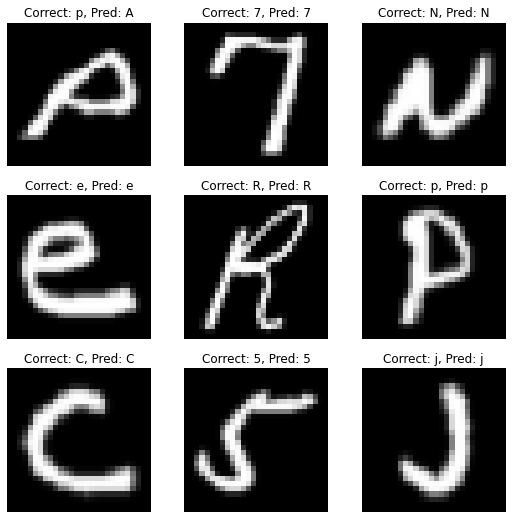

In [94]:

fig = plt.figure(figsize=(9, 9))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    rand_i = np.random.randint(len(data.data_test))
    image, label = data.data_test[rand_i]

    image_for_model = image.unsqueeze(0)  # (1, 1, 28, 28)
    logits = model(image_for_model)  # (1, C)
    pred_ind = logits.argmax(-1)  # (1, )
    pred_label = data.mapping[pred_ind]

    ax.imshow(image.reshape(28, 28), cmap='gray')
    ax.set_title(f'Correct: {data.mapping[label]}, Pred: {pred_label}')
    ax.axis(False)


In [95]:
from sklearn.metrics import classification_report

In [113]:
x, y = next(iter(data.train_dataloader()))
print(x.shape, x.dtype, x.min(), x.mean(), x.std(), x.max())
print(y.shape, y.dtype, y.min(), y.max())

torch.Size([128, 1, 28, 28]) torch.float32 tensor(0.) tensor(0.1703) tensor(0.3303) tensor(1.)
torch.Size([128]) torch.int64 tensor(4) tensor(64)


In [110]:
logits = model(x)
print(logits.shape)
preds = logits.argmax(-1)
print(y,preds)

torch.Size([128, 83])
tensor([ 5,  6, 35,  6, 19, 19, 22, 17, 37, 33,  8, 12, 11, 28, 43, 48, 28, 13,
        26, 22, 57, 25, 43, 27, 63,  8,  6, 10, 31,  9, 23, 11, 32, 55, 62, 55,
        25, 42,  4, 10, 16,  7, 41, 34, 40,  5, 44, 17, 13, 28, 19, 27, 53, 11,
        22, 36, 19, 44, 11, 14,  8, 40, 33, 19, 13, 51,  6,  5, 31,  9, 10, 62,
        12, 55, 53, 48, 42, 40, 57, 13, 29, 55, 43, 26,  8, 62, 17, 49,  5,  7,
        27,  8, 11, 22, 59,  9,  8, 47, 25, 32, 10, 35, 29, 17, 13,  8, 59, 11,
        27, 10, 38,  4,  4, 51, 20, 52, 16, 34, 41,  9, 40, 56, 19, 36, 11, 30,
        50, 12]) tensor([ 5,  6, 35,  6, 19, 19, 22, 17, 63, 33,  8, 12, 11,  4, 43, 51,  4, 13,
        26,  5, 57, 25, 40, 27, 63,  8,  6, 10, 31,  9, 23, 11, 32, 55, 62, 55,
        25, 16,  4, 10, 40,  7, 41, 34, 40,  5, 44, 17, 13, 54, 19, 27, 53, 11,
        51, 36, 19, 44, 11, 14,  8, 40, 33, 19, 13, 51,  6,  5, 31,  9, 10, 62,
        12, 29, 53, 48, 16, 40, 57, 13, 29, 17, 43, 26,  8, 62, 17,  6, 51,  7,
 

In [111]:
classification_report(y,preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

'              precision    recall  f1-score   support\n\n           4       0.50      0.67      0.57         3\n           5       0.60      0.75      0.67         4\n           6       0.80      1.00      0.89         4\n           7       1.00      1.00      1.00         2\n           8       0.86      0.86      0.86         7\n           9       1.00      1.00      1.00         4\n          10       1.00      1.00      1.00         5\n          11       1.00      1.00      1.00         7\n          12       1.00      1.00      1.00         3\n          13       1.00      1.00      1.00         5\n          14       0.50      1.00      0.67         1\n          16       0.33      0.50      0.40         2\n          17       0.80      1.00      0.89         4\n          19       1.00      1.00      1.00         6\n          20       1.00      1.00      1.00         1\n          22       1.00      0.50      0.67         4\n          23       1.00      1.00      1.00         1\n       

In [ ]:
!pip install toml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datalad

In [ ]:
!zip fsdl-text-recognizer-2021-labs.zip*folder


zip error: Nothing to do! (fsdl-text-recognizer-2021-labs.zip*folder)
